# oncRNAs Combined
Here we combine results from our BRCA cell lines results along with the pancancer BRCA oncRNAs validated in the mini-encode BRCA cell lines. From these two pool of oncRNAs we will prioritize ~100 to move forward towards experimental validations (TuD screens.)

In [1]:
import pandas as pd
import numpy as np
import os
from statsmodels.stats.multitest import fdrcorrection
import scipy.stats as stats
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from multiprocessing import cpu_count
import statsmodels
import seaborn as sns
import random
import json as js
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Merge oncRNA List

In [2]:
with open("final_list/BRCA_encode_sample_loci.json", "r") as read:   #File is copied from our miniEncode project
    cl_brca_sample_loci = js.load(read)
len(cl_brca_sample_loci)

4

In [3]:
pan_brca_oncRNA = set()
for sample,loci_dict in cl_brca_sample_loci.items():
    pan_brca_oncRNA.update(list(loci_dict.keys()))
len(pan_brca_oncRNA)

246

246 BRCA oncRNAs from pancancer analysis were present in the miniEncode BRCA samples.

In [4]:
with open("final_list/panBRCA_oncRNAs.bed", "w") as out:
    for locus in pan_brca_oncRNA:
        splits = locus.split(":")
        start = splits[1].split("-")[0]
        end = splits[1].split("-")[1]
        bed = f"{splits[0]}\t{start}\t{end}\t{locus}\t.\t{splits[-1]}"
        out.write(bed + "\n")          

In [5]:
%%bash
bedtools intersect -wo -s -a final_list/panBRCA_oncRNAs.bed -b results/thresholded_oncRNAs.bed

chr1	156701048	156701080	chr1:156701048-156701080:-	.	-	chr1	156701076	156701120	chr1:156701076-156701120:-	.	-	4
chr7	89027754	89027785	chr7:89027754-89027785:-	.	-	chr7	89027756	89027785	chr7:89027756-89027785:-	.	-	29
chr16	15576866	15576966	chr16:15576866-15576966:-	.	-	chr16	15576880	15576933	chr16:15576880-15576933:-	.	-	53
chr20	9357012	9357046	chr20:9357012-9357046:+	.	+	chr20	9357008	9357103	chr20:9357008-9357103:+	.	+	34
chr4	55336688	55336863	chr4:55336688-55336863:-	.	-	chr4	55336774	55336832	chr4:55336774-55336832:-	.	-	58


There are 4 that overlapped between the two methods. We will just merge these.

In [6]:
%%bash
cat final_list/panBRCA_oncRNAs.bed results/thresholded_oncRNAs.bed | sort -k1,1 -k2,2n | \
mergeBed -s -c 6 -o distinct -i stdin | \
awk '{print $1 "\t" $2 "\t" $3 "\t" $1":"$2"-"$3":"$4  "\t." "\t" $4  > "final_list/comb_oncRNAs.bed"}'

In [7]:
pd.read_csv("final_list/comb_oncRNAs.bed", sep="\t", header=None)

,0,1,2,3,4,5
0,chr1,2547152,2547181,chr1:2547152-2547181:+,.,+
1,chr1,2547182,2547214,chr1:2547182-2547214:+,.,+
2,chr1,23585858,23585888,chr1:23585858-23585888:+,.,+
3,chr1,31271423,31271454,chr1:31271423-31271454:-,.,-
4,chr1,35769602,35769630,chr1:35769602-35769630:+,.,+
...,...,...,...,...,...,...
349,chrX,127317121,127317153,chrX:127317121-127317153:-,.,-
350,chrX,127317160,127317210,chrX:127317160-127317210:+,.,+
351,chrX,131830554,131830602,chrX:131830554-131830602:-,.,-
352,chrX,131830762,131830937,chrX:131830762-131830937:+,.,+


Combining both results we have 354 loci, with which we generate counts and use the counts to prioritize for experimental validation.

In [8]:
%%bash
for f in data/IC/*.filter.bed; do
    base=$(basename $f)
    out=${base/.filter.bed/.onc.bed}
    bedtools intersect -wo -s -a $f -b final_list/comb_oncRNAs.bed > final_list/data/$out
done

In [9]:
%%bash
for f in /rumi/shams/jwang/cell_lines_oncRNAs/data/miniENCODE_smRNAseq/BRCA/*.filter.bed; do
    base=$(basename $f)
    out=${base/.filter.bed/.onc.bed}
    bedtools intersect -wo -s -a $f -b final_list/comb_oncRNAs.bed > final_list/data/$out
done

# Create Counts

In [10]:
cpm_map = {}
with open("final_list/BRCA_encode_cpm_map.json", "r") as read:   
    cpm_map.update(js.load(read))
with open("data/counts/cell_lines_cpm_map.json", "r") as read:
    cpm_map.update(js.load(read))
len(cpm_map)

25

In [11]:
sample_loci = {}
cancer_cell_lines = [f for f in os.scandir("final_list/data") if f.name.endswith(".onc.bed") and "HUMEC" not in f.name and "S37" not in f.name]
for f in cancer_cell_lines:
    sample = f.name.split(".")[0]
    bed = pd.read_csv(f, header=None, sep="\t")
    
    loci_features = bed[9] #Locus annotation as a feature.
    loci_bp_overlaps = bed[12] #Number of bp overlaps between read and locus annotation.
    read_ids = bed[3] #Query ID from original bamfile for each read.
    
    #First create read_id map
    read_id_locus_map = {}
    for i in range(len(read_ids)):
        _id = read_ids.iloc[i]
        num_bp_match = loci_bp_overlaps.iloc[i]
        locus = loci_features.iloc[i]
        
        if _id in read_id_locus_map: #Indicates multiple hits/overlaps for one read.
            if num_bp_match > read_id_locus_map[_id]["bp"]: #Update locus count if more number of bp matched. This is our simple binning procedure.
                read_id_locus_map[_id] = {"locus":locus, "bp":num_bp_match}
        else:
            read_id_locus_map[_id] = {"locus":locus, "bp":num_bp_match}
            
    assert len(read_id_locus_map) == len(bed[3].unique()) #Ensures we do not overcount reads   
    
    #Counts of loci
    sample_loci[sample] = {}
    for _id in read_id_locus_map: 
        locus = read_id_locus_map[_id]["locus"] 
        if locus in sample_loci[sample]:
            sample_loci[sample][locus] += cpm_map[sample]
        else:
            sample_loci[sample][locus] = cpm_map[sample]

In [15]:
len(sample_loci)

21

In [16]:
data_df = pd.DataFrame(sample_loci).fillna(0).sort_index(axis=1)
data_df.head(2)

,CN34_1_cell_S27,CN34_2_cell_S38,HCC38_1_cell_S29,HCC38_2_cell_S40,LM1a_1_cell_S28,LM1a_2_cell_S39,LM2_1_cell_S26,MCF7,MCF7_1_cell_S32,MCF7_2_cell_S43,...,MDA231_1_cell_S25,MDA231_2_cell_S36,MDA453,MDA453_1_cell_S31,MDA453_2_cell_S42,SKBR-3_1_cell_S33,SKBR-3_2_cell_S44,ZR75-1_1_cell_S34,ZR75-1_2_cell_S45,ZR751
chr1:62791710-62791745:+,0.0,0.0,0.0,2.705913,0.0,0.798053,1.665179,0.0,1.212367,0.000000,...,1.507017,0.000000,0.876165,0.825106,0.0,0.0,3.367068,1.864868,0.000000,0.0
chr1:149558545-149558588:-,0.0,0.0,0.0,1.352957,0.0,0.000000,0.832590,0.0,2.424733,1.707662,...,0.000000,0.845734,0.000000,0.000000,0.0,0.0,0.000000,1.864868,2.584353,0.0


In [17]:
binary_data_df = data_df.clip(lower=0, upper=1).apply(np.ceil).sort_index(axis=1)
print(binary_data_df.shape)
binary_data_df.head(2)

(354, 21)


,CN34_1_cell_S27,CN34_2_cell_S38,HCC38_1_cell_S29,HCC38_2_cell_S40,LM1a_1_cell_S28,LM1a_2_cell_S39,LM2_1_cell_S26,MCF7,MCF7_1_cell_S32,MCF7_2_cell_S43,...,MDA231_1_cell_S25,MDA231_2_cell_S36,MDA453,MDA453_1_cell_S31,MDA453_2_cell_S42,SKBR-3_1_cell_S33,SKBR-3_2_cell_S44,ZR75-1_1_cell_S34,ZR75-1_2_cell_S45,ZR751
chr1:62791710-62791745:+,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
chr1:149558545-149558588:-,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


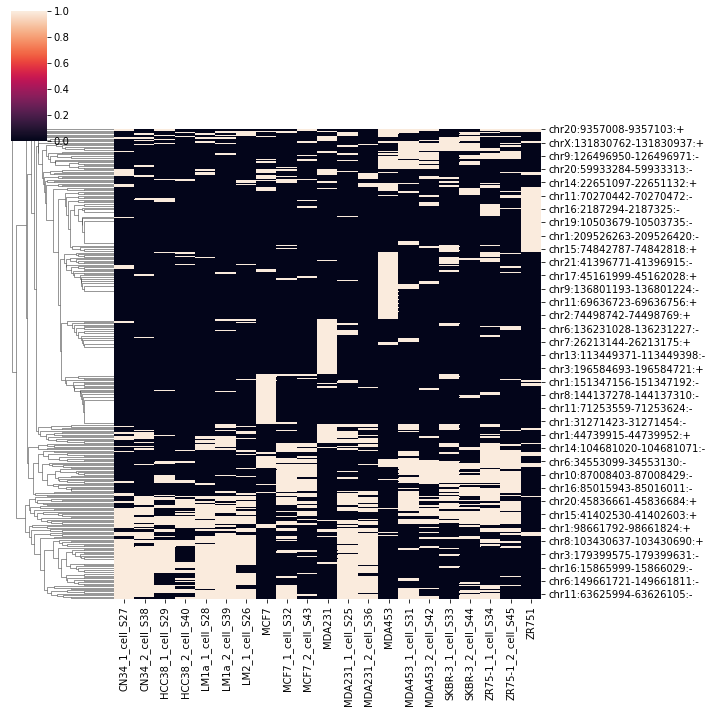

In [18]:
sns.clustermap(binary_data_df, col_cluster=False, figsize=(10,10))

# Prioritize by Cross Samples

(array([139.,  30.,  56.,  15.,  44.,  22.,  30.,   9.,   5.,   4.]),
 array([ 1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. , 11.5, 13. , 14.5, 16. ]),
 <BarContainer object of 10 artists>)

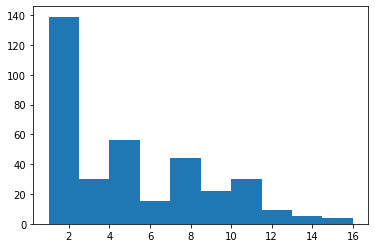

In [19]:
plt.hist(binary_data_df.sum(axis=1))

In [20]:
binary_data_df.sum(axis=1).sort_values(ascending=False)[:115]

chr9:113514723-113514767:+     16.0
chr20:9357008-9357103:+        16.0
chr19:38073696-38073718:+      15.0
chr11:112396454-112396473:+    15.0
chr7:36389850-36389931:+       14.0
                               ... 
chr2:69518038-69518065:+        7.0
chr10:87008403-87008429:-       7.0
chr5:140718716-140718745:-      7.0
chr7:38928263-38928289:-        7.0
chr17:82029608-82029640:-       6.0
Length: 115, dtype: float64

In [21]:
# Select top 114. These are oncRNAs that are at least in 7 samples
cross_sample_oncRNAs = binary_data_df.sum(axis=1).sort_values(ascending=False)[:114].index.tolist() 

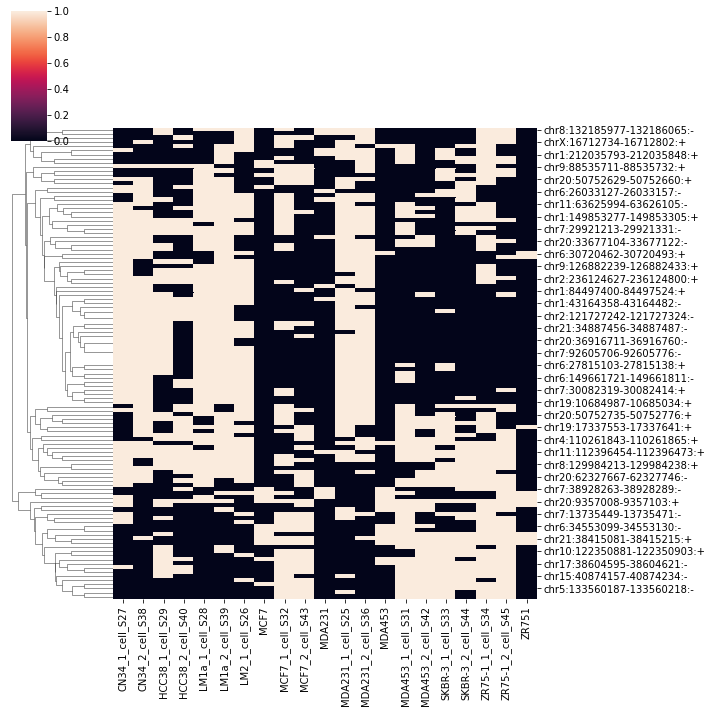

In [22]:
sns.clustermap(binary_data_df.loc[cross_sample_oncRNAs], col_cluster=False, figsize=(10,10))

# Prioritize by Expression (CPM)
Here we just take cross sample average.

In [23]:
mean_oncRNAs = data_df.mean(axis=1).sort_values(ascending=False)[:100].index.tolist() #Top 100 average

(array([291.,  42.,   9.,   5.,   0.,   1.,   1.,   3.,   0.,   2.]),
 array([0.03876276, 0.99198753, 1.94521229, 2.89843706, 3.85166182,
        4.80488659, 5.75811135, 6.71133612, 7.66456088, 8.61778564,
        9.57101041]),
 <BarContainer object of 10 artists>)

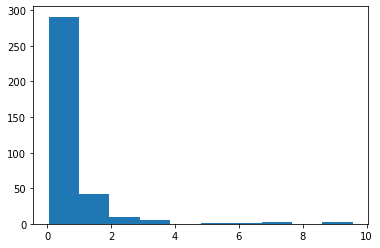

In [24]:
plt.hist(data_df.mean(axis=1))

In [25]:
max_oncRNAs = data_df.max(axis=1).sort_values(ascending=False)[:100].index.tolist() #Top 100 max in a sample

In [26]:
top_oncRNAs = set()
top_oncRNAs.update(mean_oncRNAs)
top_oncRNAs.update(max_oncRNAs)
top_oncRNAs.update(cross_sample_oncRNAs)
len(top_oncRNAs)

131

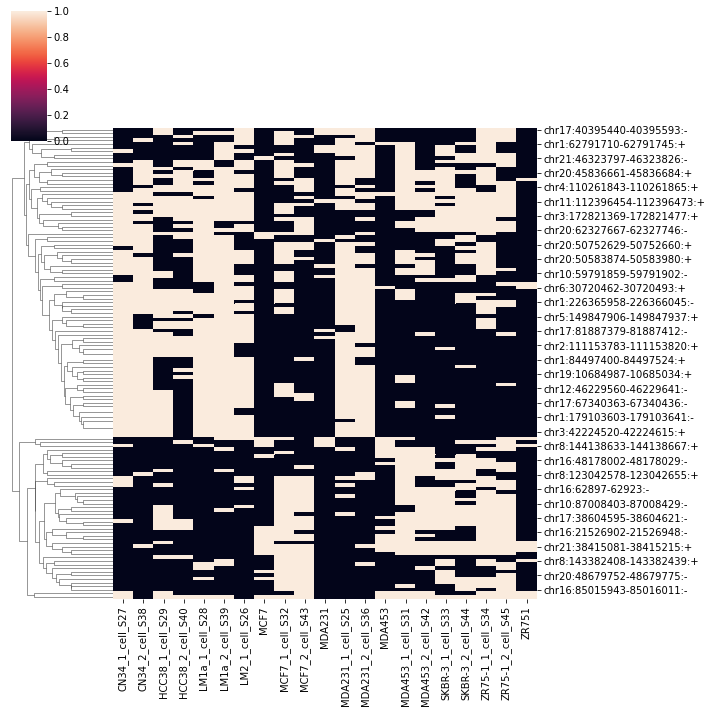

In [27]:
sns.clustermap(binary_data_df.loc[list(top_oncRNAs)], col_cluster=False, figsize=(10,10))

In [28]:
min(binary_data_df.loc[list(top_oncRNAs)].sum(axis=1))

4.0

In [29]:
#Max norm
loci_exp_df = data_df.loc[list(top_oncRNAs)].copy()
loci_df = np.zeros(loci_exp_df.shape)
for i in range(loci_exp_df.shape[0]):
    max_per_row = np.max(loci_exp_df.iloc[i])
    loci_df[i] = np.divide(loci_exp_df.iloc[i], max_per_row) #Max-norm
loci_df = pd.DataFrame(loci_df, index=loci_exp_df.index, columns=loci_exp_df.columns)
loci_df.shape

(131, 21)

<Figure size 720x720 with 0 Axes>

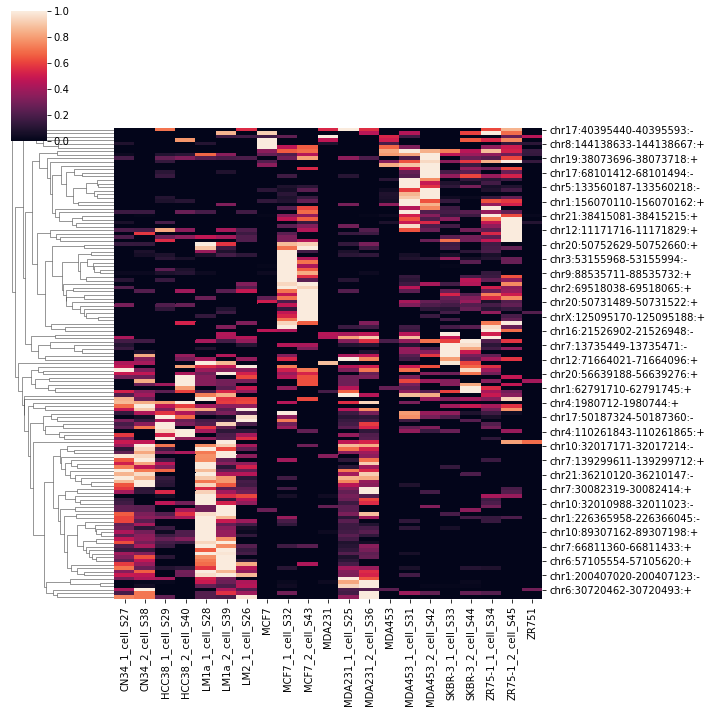

In [30]:
plt.figure(figsize=(10,10))
g=sns.clustermap(loci_df, col_cluster=False, method="average", rasterized=True)
# g.savefig("figures/cell_lines_all_sig_loci_heatmap.pdf")

# How Good Are PanCancer Represented Here

In [31]:
match = []
for i in data_df.index:
    if i in pan_brca_oncRNA:
        match.append(i)
len(match)

244

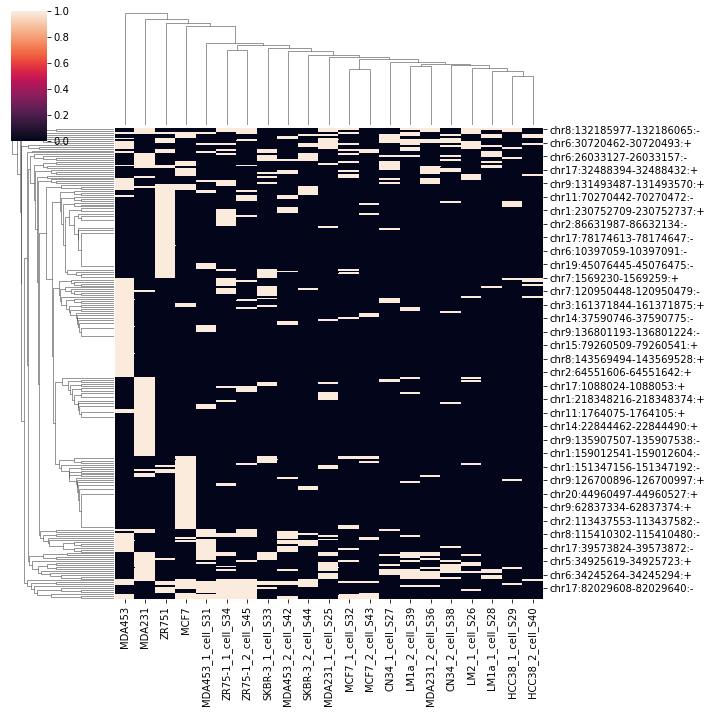

In [32]:
sns.clustermap(binary_data_df.loc[match])

In [33]:
match = []
for i in top_oncRNAs:
    if i in pan_brca_oncRNA:
        match.append(i)
len(match)

24

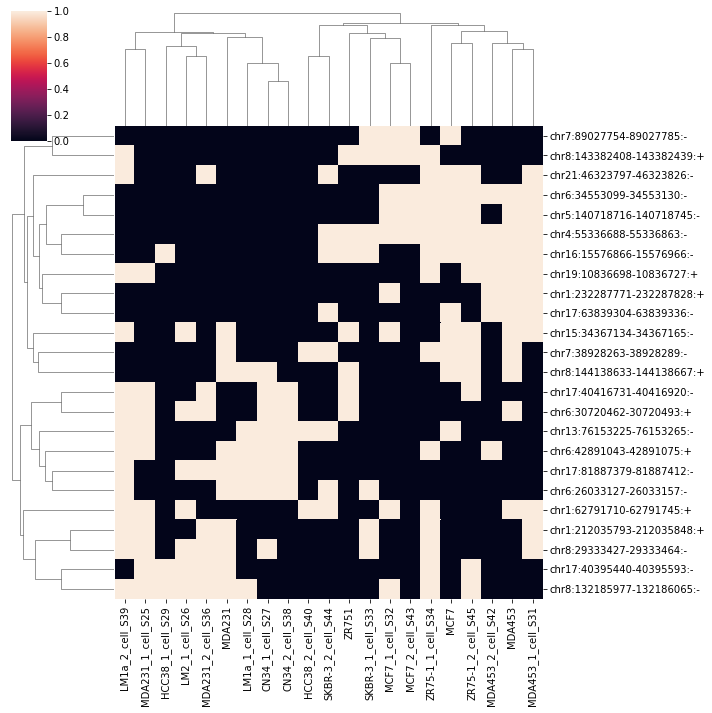

In [34]:
sns.clustermap(binary_data_df.loc[match])

# Save

In [35]:
with open("final_list/top_oncRNAs.bed", "w") as out:
    for locus in top_oncRNAs:
        splits = locus.split(":")
        start = splits[1].split("-")[0]
        end = splits[1].split("-")[1]
        bed = f"{splits[0]}\t{start}\t{end}\t{locus}\t.\t{splits[-1]}"
        out.write(bed + "\n")          

In [36]:
with open("final_list/all_sample_comb_oncRNA_loci.json", "w") as out:
    js.dump(sample_loci, out)

# Conclusion
Here we finished prioritizing BRCA oncRNAs to then move into experimental validation. Next we need to trim and finalize the sequences to for the TuD library.